# Primitive fitting



In [1]:
# Necessary imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


## Plane



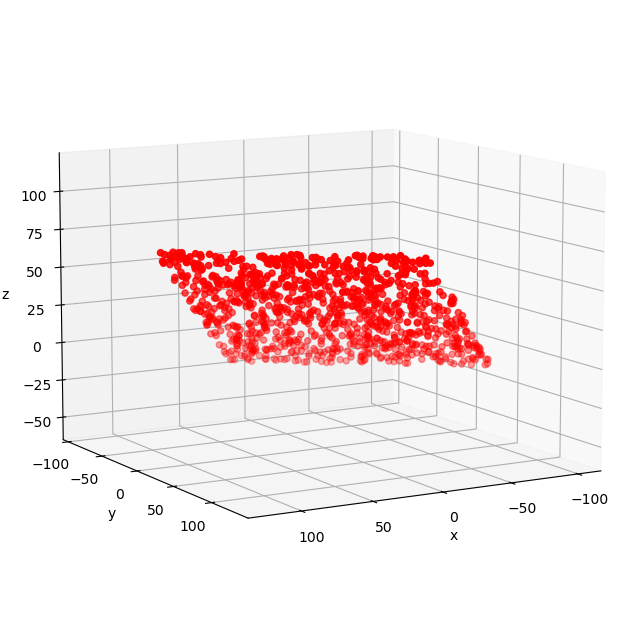

In [2]:
def generate_plane(center, normal, tangent, length, width, n=1000):

    # Start with a unit plane pointing towards z
    x = np.random.uniform(-.5, .5, (n, 1))
    y = np.random.uniform(-.5, .5, (n, 1))
    z = np.zeros((n, 1))
    points = np.hstack((x, y, z))
    # Adjust dimensions
    points[:, 0] *= length
    points[:, 1] *= width
    # Adjust orientation
    B = np.vstack([tangent, np.cross(normal, tangent), normal])
    P = np.linalg.inv(B)
    points = (B @ points.T).T
    # Adjust position
    return points + center

# Create a plane pointcloud
plane_center = np.array([10., 20., 30.])
plane_normal = np.array([0., np.sqrt(2)/2., np.sqrt(2)/2.])
plane_tangent = np.array([np.sqrt(2)/2., np.sqrt(2)/2., 0.])
plane_length = 200.
plane_width = 125.
points_plane = generate_plane(plane_center, plane_normal, plane_tangent, plane_length, plane_width)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points_plane[:, 0], points_plane[:, 1], points_plane[:, 2],
           c="red")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(10, 60)
plt.axis("equal")
plt.show()



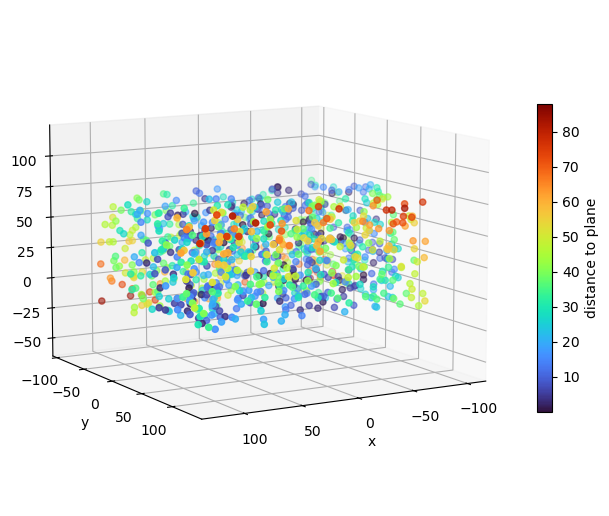

In [3]:
def dist_to_plane(points, center, normal, tangent=None, length=None, width=None):

    # Distance along all directions
    vec_to_center = points - center
    dz = vec_to_center @ normal
    dx = vec_to_center @ tangent if (tangent is not None and length is not None) else 0.
    dy = vec_to_center @ np.cross(normal, tangent) if (tangent is not None and width is not None) else 0.
    # Total distance
    return np.sqrt(dz**2 + (np.abs(dx) - length/2).clip(0)**2 + (np.abs(dy) - width/2).clip(0)**2)

# Try
random_points = np.random.uniform(points_plane.min(axis=0), points_plane.max(axis=0), (1000, 3))
dists_plane = dist_to_plane(random_points, plane_center, plane_normal, plane_tangent, plane_length, plane_width)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
p = ax.scatter(random_points[:, 0], random_points[:, 1], random_points[:, 2],
          c=dists_plane, cmap="turbo")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(10, 60)
cbar = fig.colorbar(p, shrink=0.5)
cbar.set_label('distance to plane')
plt.axis("equal")
plt.show()

    

In [4]:
def fit_plane(points):

    # Center pointcloud
    centroid = points.mean(axis=0)
    X = points - centroid
    # Covariance matrix
    cov = X.T @ X
    # Eigen decomposition
    w, v = np.linalg.eigh(cov)
    # Sum of squared residuals is equal to the smallest eingen value
    res = w[0]
    # Nomal vector
    normal = v[:, 0]
    # Tangent vector (length direction)
    tangent = v[:, 2]
    # Projection into eigen vectors basis (u=normal, v=width, w=length)
    Y = (v.T @ X.T).T
    # Length and width are the largest dimensions of the bounding box
    _, width, length = Y.ptp(axis=0)
    bb_center = (Y.max(axis=0) + Y.min(axis=0))/2
    # Center of the plane is the center of the bounding plane (v, w directions)
    shift = np.array([0., bb_center[1], bb_center[2]])
    center = centroid + v @ shift

    return (center, normal, tangent, length, width), res

# Try
parameters, res = fit_plane(points_plane)

print("Fitted sphere parameters are:", parameters)
print("Residual is", res)


Fitted sphere parameters are: (array([ 9.27701127, 19.57152684, 29.33552936]), array([ 0.37796447,  0.53452248, -0.75592895]), array([-0.91735958,  0.32635489, -0.22791203]), 234.21096756216127, 169.18283941993428)
Residual is 2.3283064365386963e-10


## Sphere


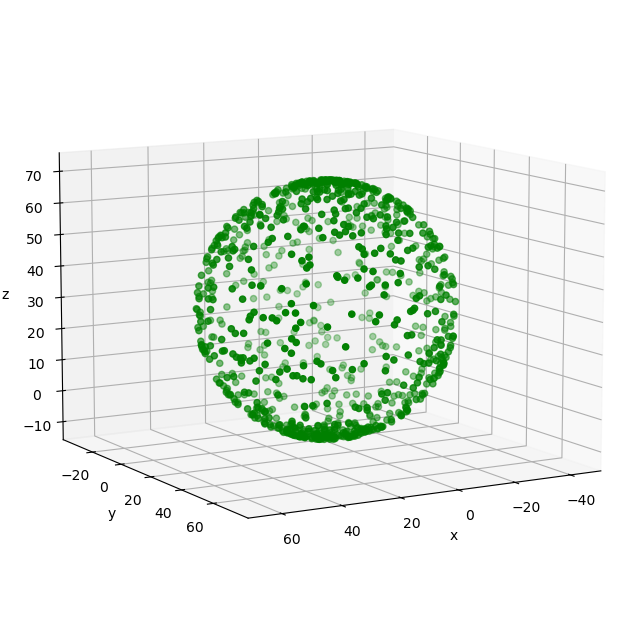

In [5]:
def generate_sphere(center, radius, n=1000):

    # Start with a unit sphere
    theta = np.random.uniform(0., np.pi, (n, 1)) 
    phi = np.random.uniform(0., 2*np.pi, (n, 1))
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    points = np.hstack((x, y, z))
    # Adjust radius
    points *= radius
    # Adjust position
    return points + center

# Create a sphere pointcloud
sphere_center = np.array([10., 20., 30.])
sphere_radius = 40.
points_sphere = generate_sphere(sphere_center, sphere_radius)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points_sphere[:, 0], points_sphere[:, 1], points_sphere[:, 2],
           c="green",)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(10, 60)
plt.axis("equal")
plt.show()


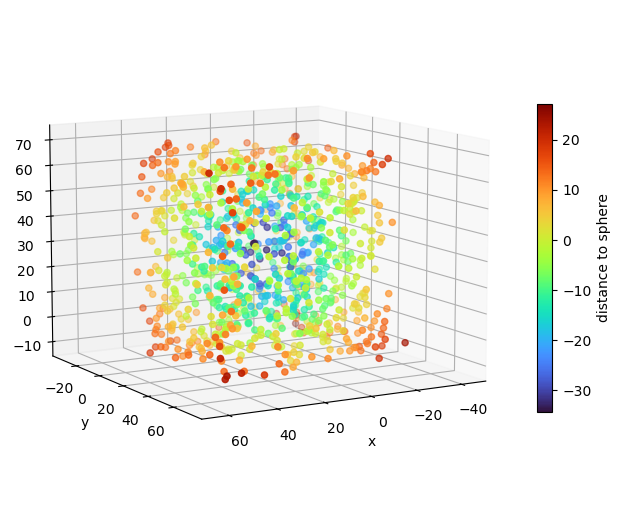

In [6]:
def dist_to_sphere(points, center, radius):

    return np.linalg.norm(points - center, axis=1) - radius

# Try
random_points = np.random.uniform(points_sphere.min(axis=0), points_sphere.max(axis=0), (1000, 3))
dists_sphere = dist_to_sphere(random_points, sphere_center, sphere_radius)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
p = ax.scatter(random_points[:, 0], random_points[:, 1], random_points[:, 2],
          c=dists_sphere, cmap="turbo")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(10, 60)
cbar = fig.colorbar(p, shrink=0.5)
cbar.set_label('distance to sphere')
plt.axis("equal")
plt.show()


In [7]:
def fit_sphere(points):

    # Coefficient matrix and values
    A = np.column_stack((2*points, np.ones(len(points))))
    b = (points**2).sum(axis=1)
    # Solve A x = b
    x, res, _, _ = np.linalg.lstsq(A, b, rcond=None)
    # Sphere parameters
    center = x[:3]
    radius = np.sqrt(x[0]**2 + x[1]**2 + x[2]**2 + x[3])
   
    return (center, radius), res

# Try
parameters, res = fit_sphere(points_sphere)

print("Fitted sphere parameters are:", parameters)
print("Residual is", res)


Fitted sphere parameters are: (array([10., 20., 30.]), 40.0)
Residual is [3.27471457e-22]


## Cylinder


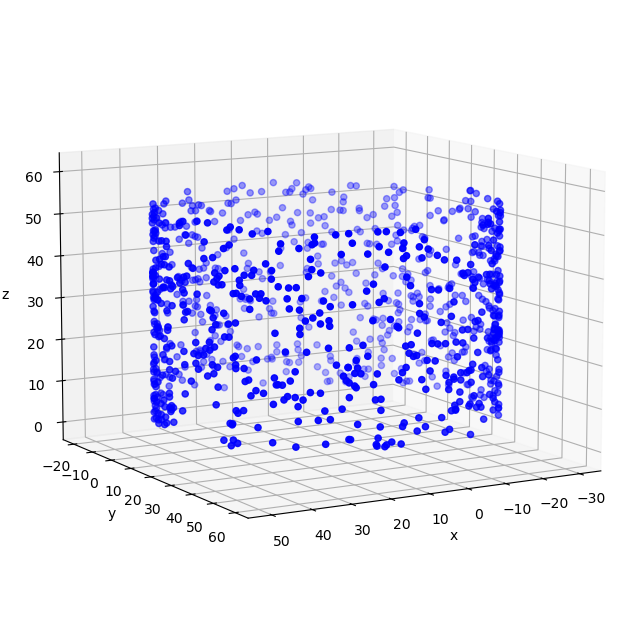

In [8]:
def generate_cylinder(center, normal, radius, length, n=1000):

    # Start with a unit cylinder pointing towards z
    theta = np.random.uniform(0., 2*np.pi, (n, 1))
    x = np.cos(theta)
    y = np.sin(theta)
    z = np.random.uniform(-0.5, 0.5, (n, 1))
    points = np.hstack((x, y, z))
    # Adjust radius and length
    points[:, :2] *= radius
    points[:, 2] *= length
    # Adjust orientation

    # Adjust center
    return points + center

# Create a cylinder pointcloud
cylinder_center = np.array([10., 20, 30.])
cylinder_normal = np.array([0., np.sqrt(2)/2., np.sqrt(2)/2.])
cylinder_radius = 40.
cylinder_length = 50.
points_cylinder = generate_cylinder(cylinder_center, cylinder_normal, cylinder_radius, cylinder_length)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points_cylinder[:, 0], points_cylinder[:, 1], points_cylinder[:, 2],
           c="blue")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(10, 60)
plt.axis("equal")
plt.show()

In [9]:
def dist_to_cylinder(points, center, normal, radius, length=None):

    # Distance to axis
    vec_to_center = points - center
    dist_to_axis = np.linalg.norm(np.cross(normal, vec_to_center))
    # Distance to lateral surface
    d_r = np.abs(dist_to_axis) - r
    if length is None:
        return d_r
    # Distance to cicles
    # TODO
    
    return d_r
    

In [10]:
def fit_cylinder(points):
    
    return


## Cone

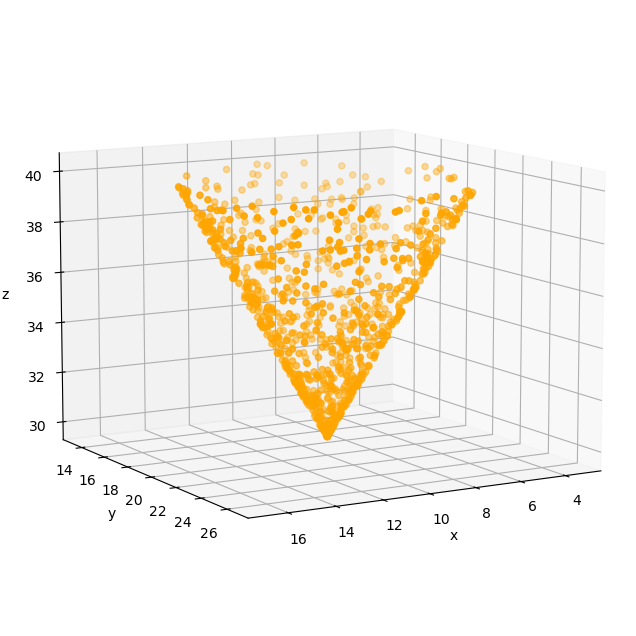

In [11]:
def generate_cone(apex, normal, half_angle, length, n=1000):
    """base radius of 1."""

    # Start with a cone of custom size pointing towards -z
    z = np.random.uniform(-0., length, (n, 1))
    theta = np.random.uniform(0., 2*np.pi, (n, 1))
    x = z * np.tan(half_angle) * np.cos(theta)
    y = z * np.tan(half_angle) * np.sin(theta)
    points = np.hstack((x, y, z))
    # Adjust rotation
    # TODO
    # Adjust position (apex)
    return points + apex

# Generate a cone pointcloud
cone_apex = np.array([10., 20., 30.])
cone_normal = np.array([0., np.sqrt(2)/2., np.sqrt(2)/2.])
cone_half_angle = np.pi/6
cone_length = 10.
points_cone = generate_cone(cone_apex, cone_normal, cone_half_angle, cone_length)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points_cone[:, 0], points_cone[:, 1], points_cone[:, 2],
           c="orange")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(10, 60)
plt.axis("equal")
plt.show()


In [12]:
def dist_to_cone(points, apex, axis, half_angle, height=None):

    # Distance to the axis
    s = np.linalg.norm(np.cross(axis, (points - apex)), axis=1)
    # Projected distance ot the cone axis
    t = (points - apex) @ axis
    # radius at t
    r = r * np.tan(half_angle)
    # Distance to lateral surface
    dist = np.abs(s - r) * np.cos(half_angle)
    # Distance to apex
    inds = np.where(t < -np.abs(t)*np.sin(half_angle))[0]
    dists[inds] = np.linalg.norm(points[inds] - apex, axis=1)
    # Distace to circle
    if height is not None:
        r_base = height * np.tan(half_angle)
        c_base = apex + height * axis
        # TODO

    return dists


In [13]:
def fit_cone(points):
    
    return


## Torus

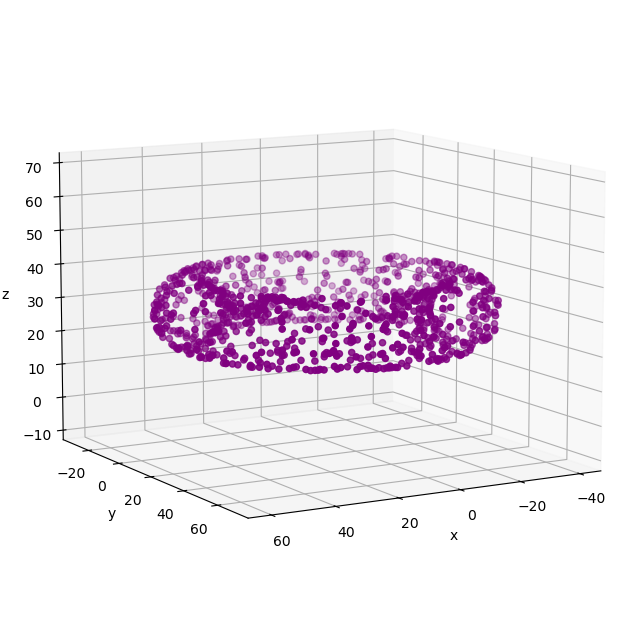

In [14]:
def generate_torus(center, normal, major_radius, minor_radius, n=1000):

    # Start with a torus of custom size pointing towards z
    theta = np.random.uniform(0., 2*np.pi, (n, 1)) 
    phi = np.random.uniform(0., 2*np.pi, (n, 1))
    x = (major_radius+ minor_radius * np.cos(theta)) * np.cos(phi)
    y = (major_radius + minor_radius * np.cos(theta)) * np.sin(phi)
    z = minor_radius * np.sin(theta)
    points = np.hstack((x, y, z))
    # Adjust orientation
    # TODO
    # Adjust position
    return points + center

# Generate a torus pointcloud
torus_center = np.array([10., 20., 30.])
torus_normal = np.array([0., np.sqrt(2)/2., np.sqrt(2)/2.])
torus_major_radius = 40
torus_minor_radius = 10.
points_torus = generate_torus(torus_center, torus_normal, torus_major_radius, torus_minor_radius)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points_torus[:, 0], points_torus[:, 1], points_torus[:, 2],
           c="purple")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(10, 60)
plt.axis("equal")
plt.show()


In [15]:
def dist_to_torus(points, center, axis, major_radius, minor_radius):

    vec_to_center = points - center
    
    s = np.linalg.norm(np.cross(axis, vec_to_center), axis=1)
    t = vec_to_center @ axis

    return np.sqrt(major_radius - s**2 + t**2) - minor_radius


In [16]:
def fit_torus(points):
    
    return
